<a href="https://colab.research.google.com/github/GonsalesAlisson/Projects/blob/develop/Demand%20Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Logistic Growth Models for modelling milk-dairy products demand
 - Alisson Vinicius Gonsales

This notebook aims to develop an index for demand for milk-dairy products in Brazil. The classical model of Logistic Growth and Volterra-Lotka Competitive model were used to model proportion of consumers to non-consumers, based on economic indices and milk-chain variables. On the next sections, the performance of each model is evaluated by analyzing the correlation between demand index and the overall milk production in Brazil.

Importing databases containing economic indices and variables from milk dairy products market.

In [131]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import MinMaxScaler

df_ipca = pd.read_excel("Indices_economicos.xlsx",header=(2),sheet_name="IPCA").set_index("Mês")
df_fecomercio = pd.read_excel("Indices_economicos.xlsx",header=(1),sheet_name="FEcomercio").set_index("Mês")
df_pnad = pd.read_excel("Indices_economicos.xlsx",header=(1),sheet_name="PNAD").set_index("Mês")
df_rendimento = pd.read_excel("Indices_economicos.xlsx",header=(0),sheet_name="Rendimento").set_index("Mês")
df_pib = pd.read_excel("Indices_economicos.xlsx",header=(0),sheet_name="PIB").set_index("Mês")
df_ipca_tot = pd.read_excel("Indices_economicos.xlsx",header=(1),sheet_name="IPCA_Tot").set_index("Mês")

atacado_df = pd.read_excel("industria.xlsx",header=(0),sheet_name='Atacado').set_index("Mês")
margens_df = pd.read_excel("industria.xlsx",header=(1),sheet_name='Margens').set_index("Mês")
estoque_df = pd.read_excel("industria.xlsx",header=(1),sheet_name='Estoque').set_index("Mês")
producao_df = pd.read_excel("industria.xlsx",header=(0),sheet_name='Captação').set_index("DATA")
atacado_sub = atacado_df[['UHT (R$/litro)','Muçarela (R$/Kg)']]
margens_sub = margens_df[['UHT','Muça']]
estoques_sub = estoque_df[['Estoque total']]

atacado_sub.columns = ['Atacado_UHT','Atacado_Muça']
margens_sub.columns = ['Margem_UHT','Margem_Muça']
estoques_sub.columns = ['Estoques']

df_fecomercio.columns = ['ICF']
icf_df = df_fecomercio.copy()

## Utils

In [8]:
def pct_change(X,n=1):
  X = np.array(X)
  R = np.zeros(len(X)-1)
  for i in range(1,len(X)-1):
    R[i] =X[i]/X[i-n] - 1
  #R[0] = np.NaN
  return R

## Classic logistic growth model: Continuous and Discrete

In [19]:
def prepare_param(K=72e6,ir_window=5,icf_window=1):
  K = 72e6                    # carrying capacity of the total population

  init_date = '2012-01-01'
  ir_window = ir_window #Window of inflation rate to be considered when doing differentiation
  icf_window = icf_window

  #Estimate of initial population with the unemployment index
  N0 = int((1 - np.array(df_pnad['2012-03-01':'2012-03-01'])[0][0])*K)

  t0 = 0                       # start time for continuous model
  tf = 50                      # end time for continuous model
  n = len(icf_df[init_date:]) -1                  # number of time points
  dt = (tf - t0) / (n - 1)     # time step size
  t = np.linspace(t0, tf, n)   # time vector

  consumption_intention_rate = icf_df
  consumption_intention_rate = MinMaxScaler(feature_range=(0,1)).fit_transform(consumption_intention_rate.loc[init_date:])


  inflation_rate = df_ipca[['Leite e Derivados']].dropna()
  #rolling_var_if = df_ipca['Leite e Derivados'].rolling(window=ir_window+1,closed='right',center=False).var().dropna()

  inflation_rate_adj = pd.DataFrame(np.array(1.0/inflation_rate['Leite e Derivados']),
                                  index=inflation_rate.index)

  inflation_rate_adj = MinMaxScaler(feature_range=(0,1)).fit_transform(inflation_rate_adj.loc[init_date:])

  #Estimate of initial population of milk dairy products consumers by milk production index
  S0 = int(N0/5)

  return N0, S0, inflation_rate_adj,consumption_intention_rate,K,t,dt

In [3]:
def logistic_growth(N0,S0, r,r2, K, t):
    N = np.zeros(t.shape)
    S = np.zeros(t.shape)
    N[0] = N0
    S[0] = S0
    r = r 
    r2 = r2 
    for i in range(1, len(t)):
        dNdt = r[i-1] * N[i-1] * (1 - N[i-1]/K)
        N[i] = N[i-1] + dNdt * dt
        dSdt = r2[i-1]*S[i-1]*(1 - S[i-1]/N[i-1])
        S[i] = S[i-1] + dSdt * dt
    return N,S

In [4]:
def logistic_growth_discrete(N0, S0, r, r2, K, t,dt):
    N = np.zeros(t.shape)
    S = np.zeros(t.shape)
    N[0] = N0
    S[0] = S0
    r = r 
    r2 = r2 
    for i in range(1, len(t)):
        dNdt = r[i-1] * N[i-1] * (1 - N[i-1]/K)
        N[i] = N[i-1] + int(dNdt * dt)
        dSdt = r2[i-1] * S[i-1] * (1 - S[i-1]/N[i])
        S[i] = S[i-1] + int(dSdt * dt)
    return N,S

In [5]:
def to_plot(N,S):
  fig, ax = plt.subplots(figsize=(8,6))
  ax.plot(N,label="Number of active households",color='red')
  plt.legend()
  ax1 = ax.twinx()
  ax1.plot(S,label="Number of MDPC households",color='blue')
  plt.legend()
  plt.show()

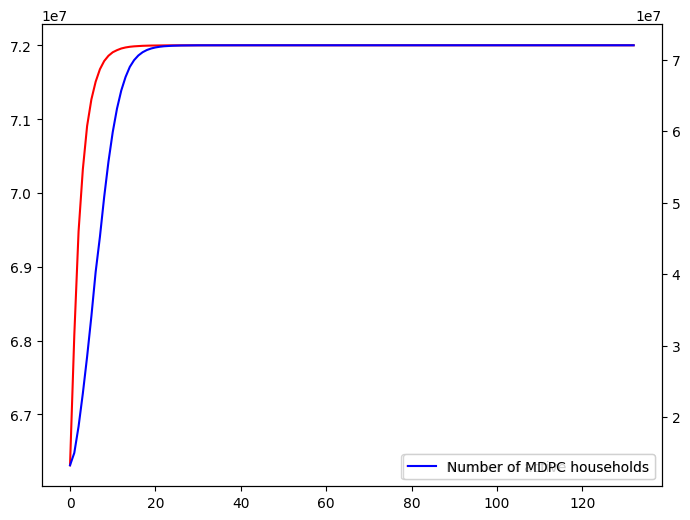

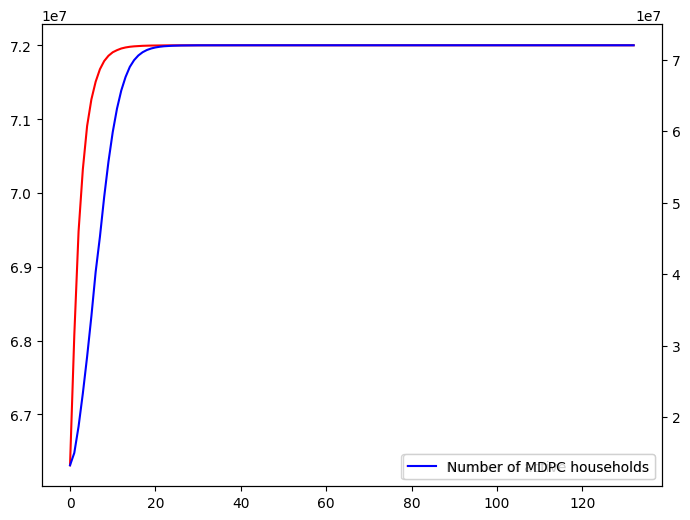

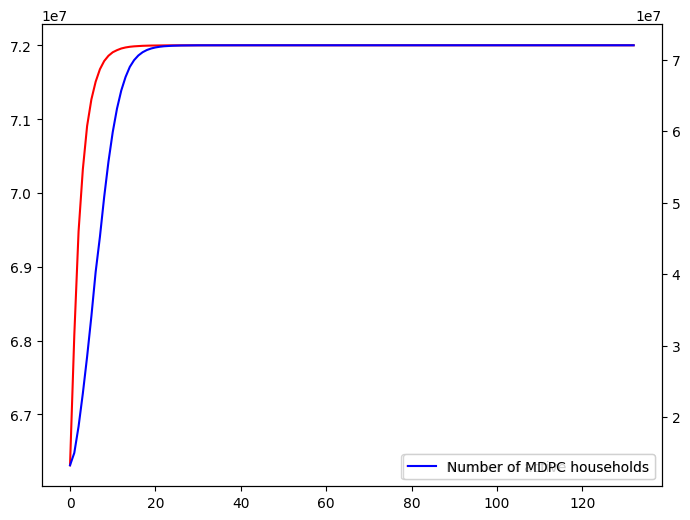

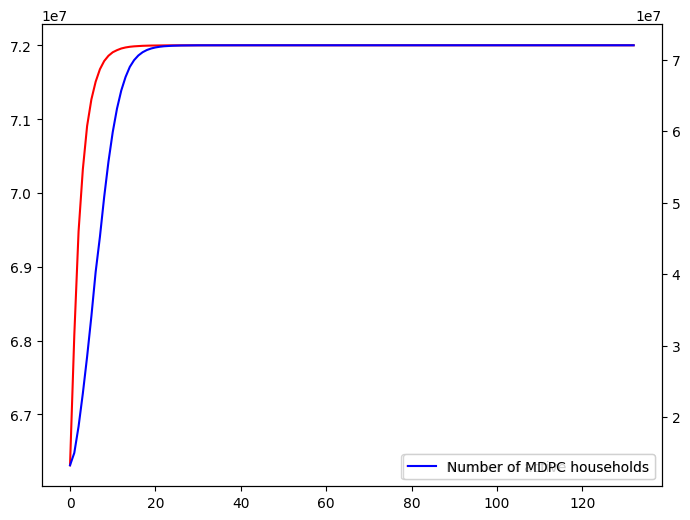

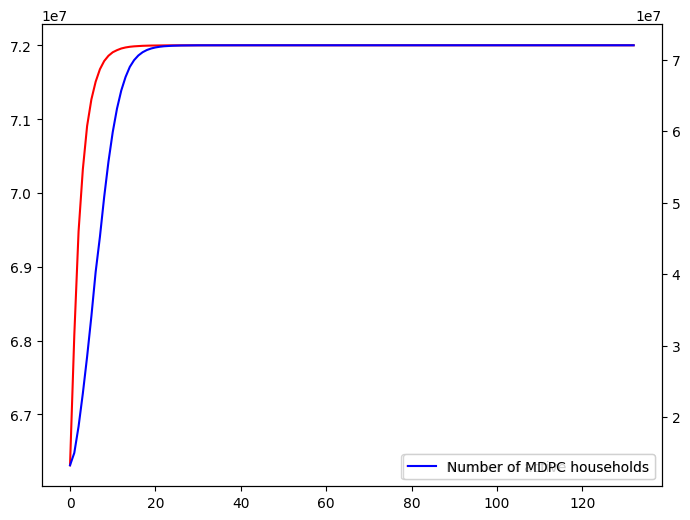

In [21]:
for ir_window in [1,2,3,4,5]:
  N0, S0, inflation_rate_adj, consumption_intention_rate,K,t,dt = prepare_param(ir_window=ir_window,icf_window=1)
  N,S = logistic_growth_discrete(N0=N0,S0=S0,r=consumption_intention_rate,r2=inflation_rate_adj,K=K,t=t,dt=dt)
  to_plot(N,S)

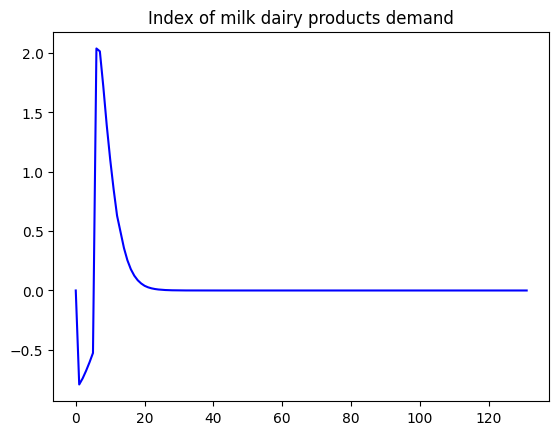

In [22]:
plt.plot(pct_change(S,6),color='blue',label="Index")
plt.title("Index of milk dairy products demand")
plt.show()

On this classical model, we tried to simulate a total population of Consumers and set this population as the carrying capacity for a new population of milk consumers. The growth rates of each population: (ICF - "Intenção de Consumo das famílias) and (IPCA - Índice de preços no consumidor)**1.0/IPCA was used**, are economic indices that can measure intention of consumption and inflation. The results show us that the nature of constant growth of the model just causes the plateau of each population to be lagged. A better model would incorporate flutuations on intention of consumption. A good candidate is the Volterra-Lotka competitive classic model of prey-predator.

## Volterra-Lotka competitive model 

In [23]:
def volterra_lotka(x, y, a, b, c, d):
    #print(a,b,c,d)
    dx = a*x - b*x*y
    dy = c*x*y - d*y
    return dx, dy

In [24]:
def competitive_volterra_lotka(x,y,r1,r2,a12,a21,Kx,Ky):
  dx = r1*x*(1-(x+a12*y)/Kx)
  dy = r2*y*(1-(y+a21*x)/Ky)
  return dx, dy

In [25]:
def iterate_voltera_lotka(x0, y0, a, b, c, d,t,dt,Kx=300,Ky=300):
  x = np.zeros(t.shape)
  y = np.zeros(t.shape)
  x[0] = x0
  y[0] = y0
  n_iter2 = 5
  Kx = Kx
  Ky = Ky
  param_count = 1
  for i in range(1, len(t)):
    xk = [x[i-1]]
    yk = [y[i-1]]
    param_count = i
    for k in range(n_iter2):
      #print(a[param_count -1],b[param_count-1],c[param_count-1],d[param_count-1])
      dxdt, dydt = competitive_volterra_lotka(xk[-1], yk[-1], a[param_count-1], b[param_count-1], c[param_count-1], d[param_count-1],Kx,Ky)
      xk.append(xk[-1] + dxdt*dt)
      yk.append(yk[-1] + dydt*dt)
    x[i] = np.mean(xk)
    y[i] = np.mean(yk)
  
  return x, y

In [26]:
def prepare_param_vl(icf_window=5,uht_window=1,icf_df=None,df_ipca=None):
  #x is the number of milk dairy products consumers
  #y is the number of non-milk dairy products consumers
  #a = growth rate of milk dairy products consumers (ICF)
  #b = death rate of non-milk dairy products consumers (1.0/UHT)
  #c = death rate of milk dairy products consumers (UHT)
  #d = growth rate of non-milk dairy products consumers (IPCA)

  init_date = '2014-08-01'
  end_date = '2023-02-01'
  t0 = 0                       # start time for continuous model
  tf = 50                      # end time for continuous model
  n = len(icf_df[init_date:end_date])                  # number of time points
  dt = (tf - t0) / (n - 1)     # time step size
  t = np.linspace(t0, tf, n)   # time vector

  consumption_intention_rate = icf_df
  consumption_intention_rate = MinMaxScaler(feature_range=(0,1)).fit_transform(consumption_intention_rate.loc[init_date:end_date])


  inflation_rate = df_ipca[['IPCA']]
  #rolling_var_if = df_ipca['Leite e Derivados'].rolling(window=ir_window+1,closed='right',center=False).var().dropna()
  inflation_rate_adj = inflation_rate

  inflation_rate_adj = MinMaxScaler(feature_range=(0,1)).fit_transform(inflation_rate_adj.loc[init_date:end_date])

  inv_uht_price = np.array(1.0/atacado_sub[['Atacado_UHT']].loc[init_date:end_date])
  uht_price = atacado_sub[['Atacado_UHT']]
  uht_price = MinMaxScaler(feature_range=(0,1)).fit_transform(uht_price.loc[init_date:end_date])
  return consumption_intention_rate,inv_uht_price,uht_price,inflation_rate_adj,t,dt



In [27]:
#x is the number of milk dairy products consumers
#y is the number of non-milk dairy products consumers
#a = growth rate of milk dairy products consumers (ICF)
#b = death rate of non-milk dairy products consumers (UHT price)
#c = death rate of milk dairy products consumers (IPCA)
#d = growth rate of non-milk dairy products consumers (=c)


init_date = '2014-08-01'
end_date = '2023-03-01'

date_range = pd.date_range(start=init_date, end=end_date, freq='M')

# Define the parameters
a,b,c,d,t,dt = prepare_param_vl(icf_df=icf_df,df_ipca=df_ipca)
#print(len(a[0]),len(b[0]),len(c[0]),len(d[0]),len(t[0]))
# Define the initial conditions
x0_list = [50,100,200,250]
y0_list = [50,100,200,250]
q_list = []
for x0 in x0_list:
  for y0 in y0_list:
    x,y = iterate_voltera_lotka(x0, y0, a, b, c, d,t,dt)
    q_list.append(abs(x)/abs(y))

/usr/local/lib/python3.9/dist-packages/numpy/core/_methods.py:163: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asanyarray(a)


A competitive Volterra-Lotka was used considering two populations: Consumers of milk products and Non-Consumers of milk products.

$$ \frac{dx}{dt}  = r_1x(1 - \frac{x+\alpha_{12}y}{Kx}) $$

$$ \frac{dy}{dt}  = r_2y(1 - \frac{y+\alpha_{21}x}{Ky}) $$

$r_1:$ Growth rate of consumers (ICF index)

$r_2:$ Growth rate of Non-consumers (IPCA index)

$\alpha_{12}:$ Death rate of Non-Consumers (1.0/UHT price)

$\alpha_{21}:$ Death rate of Consumers (UHT price)

 The carrying capacities were the same each population. Each parameter actualization was made on a fixed number of timesteps(5 was used). The time-series parameters was normalized by MinMaxRange. The image below shows the Q-factor: quotient of consumers to non-consumers over time for a list of initial conditions. We can see that the series always converge to a steady state solution.

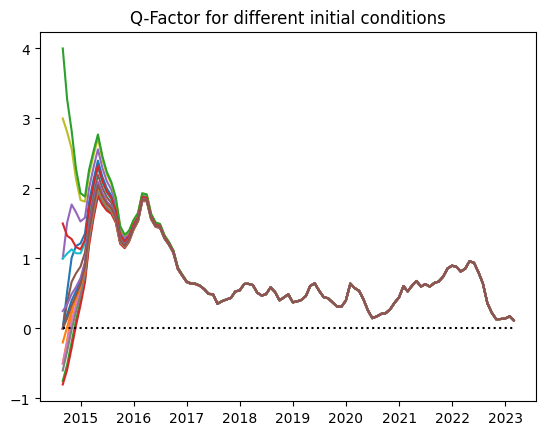

In [40]:
for q in q_list:
  plt.plot(date_range,q-1.0)
plt.hlines(xmin=date_range[0],xmax=date_range[-1],y=0,color='black',linestyle='dotted')
plt.title("Q-Factor for different initial conditions")
plt.savefig("q_plot.png")
plt.show()

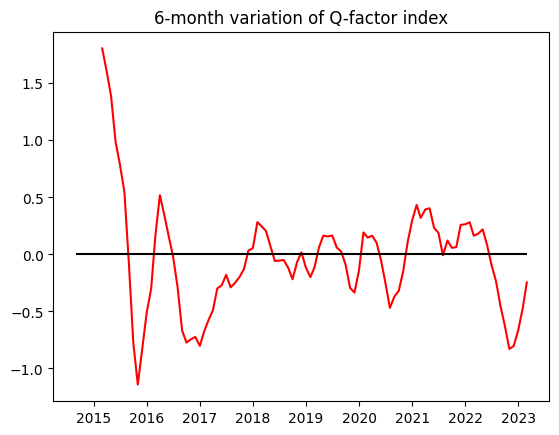

In [114]:
q_df = pd.DataFrame(q_list[0] - 1)
#plt.plot(q_df.diff(1))
#plt.plot(q_df.diff(2))
#plt.plot(q_df.diff(4))
fig, ax =plt.subplots()
q_df.index = date_range
ax.plot(q_df.diff(6),color='red')
#ax1 = ax.twinx()
#ax1.plot(np.array(producao_df['2014-08-01':]))
plt.hlines(y=0,xmin=date_range[0],xmax=date_range[-1],color='black')
plt.title("6-month variation of Q-factor index")
plt.savefig("semestral.png")
plt.show()

The question remaining is: There is any significant correlation between this index and milk production data? If this was the case, we could just project demand for milk products by economic indices projections.

In [132]:
init_date = '2014-08-01'
end_date = '2023-03-01'
producao_df.loc[init_date:end_date,'qf'] = q_list[0] - 1

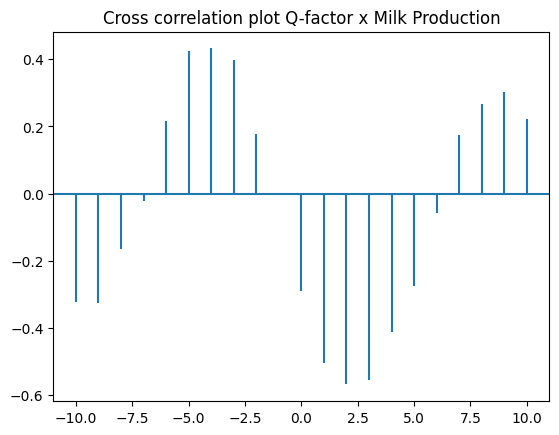

In [144]:
#prod_diff_1 = np.array(producao_df['PRODUCAO'].diff().loc['2015-01-01':'2022-10-01'])
producao_df['prod_diff_6'] =  producao_df['PRODUCAO'].diff(6)
producao_df['qf_diff_6'] = producao_df['qf'].diff(6)
producao_df.dropna(inplace=True)
plt.xcorr(producao_df['prod_diff_1'],producao_df['qf_diff_6'],normed=True)
plt.title("Cross correlation plot Q-factor x Milk Production")
plt.show()

The cross-correlation plot above shows that there is periodic inversion of correlations between milk production and the proposed index when considering the 6-month variation. This effect can be due to the seasonality changes of the milk chain key variables: Climate, Grains price, Milk production, Consume patterns. Below, we show a scatterplot of 

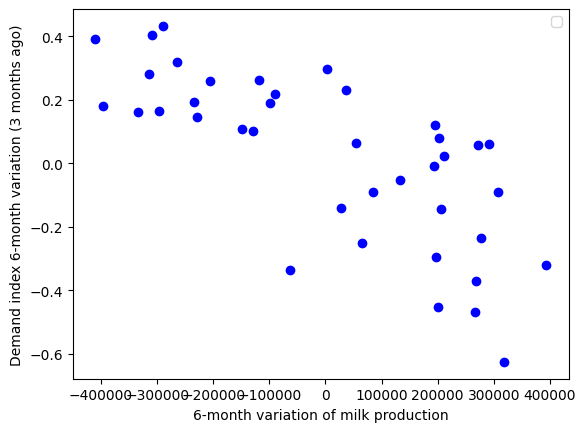

In [157]:
plt.scatter(producao_df['prod_diff_6'],producao_df['qf_diff_6'].shift(3),color='blue')
plt.xlabel("6-month variation of milk production")
plt.ylabel("Demand index 6-month variation (3 months ago)")
plt.legend()
plt.savefig("Index_production_demand.png")

A key factor to understand the correlation of the proposed index with milk production is the UHT price that was incorporated in the model.

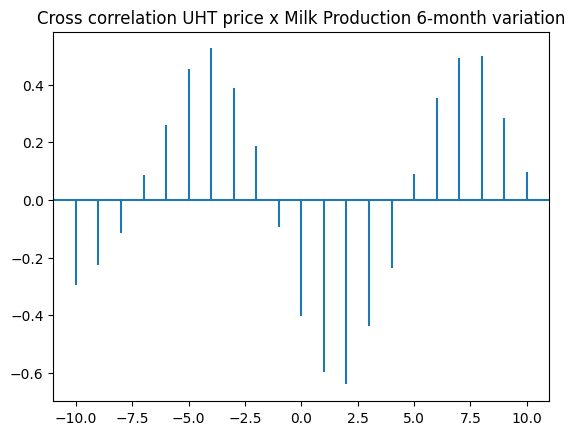

In [166]:
producao_df['uht'] = atacado_sub['Atacado_UHT'].diff(6)
plt.xcorr(producao_df['uht'],producao_df['prod_diff_6'])
plt.title("Cross correlation UHT price x Milk Production 6-month variation")
plt.show()

There is a correlation of -60% between the milk production 1-2 months ago and the UHT prices now. A good milk production means lower prices. The rate of milk consumers must increase. But also there is a correlation of 40-50% between the UHT prices some months ago and the milk production. Not all these correlations can be causal effects. But we can see how the cyclic process of the entire milk chain can be observed on it's variables. 

# Conclusions

The Volterra-Lotka competitive model seems to be a interesting idea to modelling the proportion of consumption. The model was applied to milk=dairy products consumers/non-consumers and an index was proposed. We saw that the index can capture some relations of the growth/death rates choosen and the correlations of the index with key variables of milk seems to reproduce the known seasonality process of some of these variables. In the future, a careful study of each rate should be done and the model complexity could be improved by adding ML techniques.